In [1]:
!unzip roboflow_yolov9.zip -d .

Archive:  roboflow_yolov9.zip
 extracting: ./README.dataset.txt    
 extracting: ./README.roboflow.txt   
 extracting: ./data.yaml             
   creating: ./test/
   creating: ./test/images/
 extracting: ./test/images/01F3MMVYT4SJ23G9XQQ3S8BKNE_jpeg.rf.5baee614d965f81a1073e541414be2f2.jpg  
 extracting: ./test/images/01F3MMW28Z2J8R32ZE4BECFRS8_jpeg.rf.d0371faa8032c3e0a9a0a240eb865cbf.jpg  
 extracting: ./test/images/01F3MMWMF7H96ADJ3YGF5TA1KM_jpeg.rf.196ace2416ade2ef1d3058d90a4a6407.jpg  
 extracting: ./test/images/01F3MMX1JKX31TSGA6GK7S16T1_jpeg.rf.ad689bc304ad18e64b556dee9d129f03.jpg  
 extracting: ./test/images/01F3MMX2RXFSJV79X3QMF6XXW8_jpeg.rf.70852653b5a6585b8cc4a9fb4ba270ac.jpg  
 extracting: ./test/images/01F3MMXD1283Z6TWREGFWXYSQM_jpeg.rf.2df9488cae02356a3558fd6a74b7dc71.jpg  
 extracting: ./test/images/01F3MMY1W7BKARQ7SMST6FA3WF_jpeg.rf.dbc0b5319a634df60255703c04f99209.jpg  
 extracting: ./test/images/01F3MMY37WC5S8V9A3VD4X56PT_jpeg.rf.3349d9c8ecbfe8ab3c593b8a7fcc5e0c.jpg  

In [2]:
# crop_multi_class.py
import os, math, random
from pathlib import Path
from PIL import Image

# === EDIT THESE PATHS ===
DATASET_ROOT = Path("roboflow_yolov9")
OUT_ROOT = Path("image_crops_classes")
CLASS_NAMES = [
    "blackheads",
    "dark_spot",
    "nodules",
    "papules",
    "pustules",
    "whiteheads"
]
NEGATIVE_PER_IMAGE = 0   # set >0 to generate "clear" negatives
MIN_NEG_AREA = 0.02
MAX_NEG_AREA = 0.25
# ========================

OUT_ROOT.mkdir(parents=True, exist_ok=True)

def read_yolo(label_path):
    with open(label_path, "r") as f:
        lines = []
        for line in f:
            parts = line.strip().split()
            if len(parts) < 5:
                continue
            cls = int(parts[0])
            vals = list(map(float, parts[1:5]))
            lines.append((cls, vals))
    return lines

def yolo_to_pixels(xc,yc,w,h, W,H):
    cx = xc*W; cy = yc*H
    bw = w*W; bh = h*H
    x1 = int(max(0, cx - bw/2))
    y1 = int(max(0, cy - bh/2))
    x2 = int(min(W, cx + bw/2))
    y2 = int(min(H, cy + bh/2))
    return x1,y1,x2,y2

def iou(a,b):
    xA = max(a[0], b[0]); yA = max(a[1], b[1])
    xB = min(a[2], b[2]); yB = min(a[3], b[3])
    interW = max(0, xB-xA); interH = max(0, yB-yA)
    inter = interW*interH
    areaA = (a[2]-a[0])*(a[3]-a[1])
    areaB = (b[2]-b[0])*(b[3]-b[1])
    union = areaA + areaB - inter
    if union==0: return 0
    return inter/union

for split in ["train","valid","test"]:
    img_dir = DATASET_ROOT / split / "images"
    lbl_dir = DATASET_ROOT / split / "labels"
    if not img_dir.exists():
        print("Missing split:", split); continue

    # create class folders
    for cname in CLASS_NAMES:
        (OUT_ROOT / split / cname).mkdir(parents=True, exist_ok=True)
    # optional negatives
    if NEGATIVE_PER_IMAGE > 0:
        (OUT_ROOT / split / "clear").mkdir(parents=True, exist_ok=True)

    for img_path in sorted(img_dir.glob("*")):
        try:
            img = Image.open(img_path).convert("RGB")
        except Exception as e:
            print("can't open", img_path, e); continue
        W,H = img.size
        label_file = lbl_dir / f"{img_path.stem}.txt"
        boxes = []
        if label_file.exists():
            for i,(cls,vals) in enumerate(read_yolo(label_file)):
                x1,y1,x2,y2 = yolo_to_pixels(vals[0], vals[1], vals[2], vals[3], W, H)
                if x2 <= x1 or y2 <= y1:
                    print(f"Skipped invalid bbox {img_path.name} line {i}")
                    continue
                boxes.append(((x1,y1,x2,y2), cls))
                # save crop
                cname = CLASS_NAMES[cls] if cls < len(CLASS_NAMES) else f"class_{cls}"
                outp = OUT_ROOT / split / cname / f"{img_path.stem}_{i}.jpg"
                img.crop((x1,y1,x2,y2)).save(outp, quality=95)

        # create negatives (optional)
        if NEGATIVE_PER_IMAGE > 0:
            for ni in range(NEGATIVE_PER_IMAGE):
                tries = 0
                while tries < 60:
                    area_frac = random.uniform(MIN_NEG_AREA, MAX_NEG_AREA)
                    side = int(math.sqrt(area_frac * (W*H)))
                    if side < 32:
                        side = min(32, min(W,H))
                    x1 = random.randint(0, max(0, W-side))
                    y1 = random.randint(0, max(0, H-side))
                    x2 = x1 + side; y2 = y1 + side
                    candidate = (x1,y1,x2,y2)
                    bad = False
                    for b,_ in boxes:
                        if iou(candidate, b) > 0.02:
                            bad = True; break
                    if not bad:
                        outp = OUT_ROOT / split / "clear" / f"{img_path.stem}_neg{ni}.jpg"
                        img.crop(candidate).save(outp, quality=95)
                        break
                    tries += 1

print("Done. Cropped images in:", OUT_ROOT)


Skipped invalid bbox 10_jpg.rf.07660da7415528682fc97bafce85457e.jpg line 2
Skipped invalid bbox 10_jpg.rf.8778847616b64313aea48c22a0cf1895.jpg line 2
Skipped invalid bbox levle1_421_jpg.rf.74bdc0ccdd9a114da19a0d3e6938d9e1.jpg line 4
Skipped invalid bbox levle1_421_jpg.rf.79dee8cc3ff2e745a1c1143818280096.jpg line 4
Done. Cropped images in: image_crops_classes


In [6]:
from torchvision import transforms

# ----------------------------
# IMAGE TRANSFORMS
# ----------------------------
train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

val_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])


In [10]:
from torchvision import datasets

train_dataset = datasets.ImageFolder(root='/content/image_crops_classes/train', transform=train_transforms)
valid_dataset = datasets.ImageFolder(root='/content/image_crops_classes/valid', transform=val_transforms)
test_dataset  = datasets.ImageFolder(root='/content/image_crops_classes/test',  transform=val_transforms)


In [11]:
train_dataset.classes

['blackheads', 'dark_spot', 'nodules', 'papules', 'pustules', 'whiteheads']

In [15]:
# train_resnet_multi.py (key parts shown)
from torchvision import datasets, transforms, models
from collections import Counter
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import WeightedRandomSampler, DataLoader
import torch

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)
DATA_DIR = "image_crops_classes"
train_ds = datasets.ImageFolder(DATA_DIR + "/train", transform=train_transforms)
val_ds   = datasets.ImageFolder(DATA_DIR + "/valid", transform=val_transforms)
test_ds  = datasets.ImageFolder(DATA_DIR + "/test", transform=val_transforms)

BATCH_SIZE = 16
class_names = train_ds.classes
NUM_CLASSES = len(class_names)
print("Classes:", class_names)  # verify order matches CLASS_NAMES

# Weighted sampler / class weights
train_counts = Counter([y for _,y in train_ds.samples])
class_sample_counts = [train_counts[i] for i in range(NUM_CLASSES)]
print("Counts per class:", class_sample_counts)

# Option A: WeightedRandomSampler to balance sampling
weights = [1.0 / train_counts[target] for _, target in train_ds.samples]
sampler = WeightedRandomSampler(weights, num_samples=len(weights), replacement=True)
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, sampler=sampler, num_workers=4)

# Build model
model = models.resnet50(pretrained=True)
model.fc = nn.Linear(model.fc.in_features, NUM_CLASSES)
model = model.to(DEVICE)

# (freeze/unfreeze logic same as before)

# Option B: Class-weighted loss (useful if not using sampler)
class_weights = torch.tensor([sum(class_sample_counts)/c for c in class_sample_counts], dtype=torch.float).to(DEVICE)
criterion = nn.CrossEntropyLoss(weight=class_weights)


Using device: cuda
Classes: ['blackheads', 'dark_spot', 'nodules', 'papules', 'pustules', 'whiteheads']
Counts per class: [637, 2523, 215, 1749, 1138, 1478]


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNe

In [18]:
test_loader = DataLoader(test_dataset,
                         batch_size=BATCH_SIZE,
                         shuffle=False,
                         num_workers=2)


In [19]:
from sklearn.metrics import classification_report, confusion_matrix
y_true, y_pred = [], []
with torch.no_grad():
    for imgs, labels in test_loader:
        imgs = imgs.to(DEVICE)
        outs = model(imgs)
        preds = torch.argmax(outs, dim=1).cpu().numpy()
        y_pred.extend(preds.tolist())
        y_true.extend(labels.numpy().tolist())

print(classification_report(y_true, y_pred, target_names=test_ds.classes, digits=4))


              precision    recall  f1-score   support

  blackheads     0.0000    0.0000    0.0000        34
   dark_spot     0.4023    0.2727    0.3251       385
     nodules     0.0438    0.1304    0.0656        46
     papules     0.1212    0.0432    0.0637       185
    pustules     0.0000    0.0000    0.0000       129
  whiteheads     0.1481    0.4722    0.2255       144

    accuracy                         0.2026       923
   macro avg     0.1192    0.1531    0.1133       923
weighted avg     0.2174    0.2026    0.1868       923



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Classification Report:

              precision    recall  f1-score   support

  blackheads     0.0000    0.0000    0.0000        34
   dark_spot     0.4372    0.2442    0.3133       385
     nodules     0.0303    0.0652    0.0414        46
     papules     0.1546    0.0811    0.1064       185
    pustules     0.0000    0.0000    0.0000       129
  whiteheads     0.1699    0.6042    0.2652       144

    accuracy                         0.2156       923
   macro avg     0.1320    0.1658    0.1211       923
weighted avg     0.2414    0.2156    0.1955       923



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


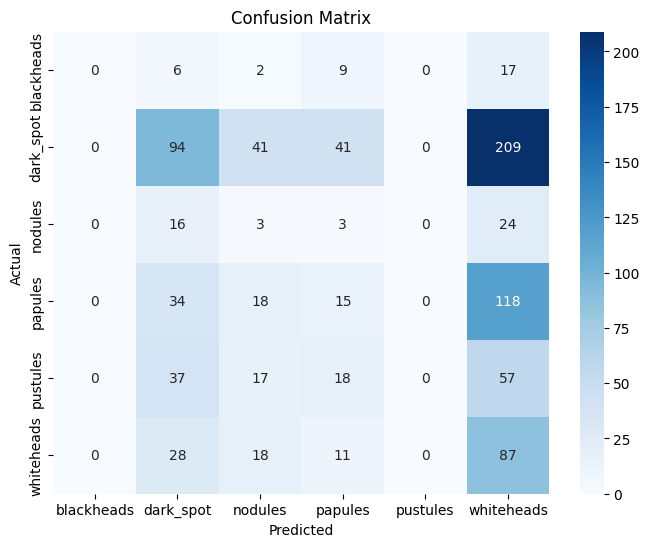

In [22]:
import torch
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# -------------------------
# Make sure these exist
# -------------------------
# test_dataset and test_loader
test_dataset = datasets.ImageFolder(
    root="/content/image_crops_classes/test",
    transform=val_transforms
)

test_loader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=2
)

# -------------------------
# Evaluation
# -------------------------
y_true, y_pred = [], []

model.eval()
with torch.no_grad():
    for imgs, labels in test_loader:
        imgs = imgs.to(DEVICE)
        labels = labels.to(DEVICE)
        outs = model(imgs)
        preds = torch.argmax(outs, dim=1)

        y_pred.extend(preds.cpu().numpy())
        y_true.extend(labels.cpu().numpy())

# -------------------------
# Classification report
# -------------------------
print("Classification Report:\n")
print(classification_report(
    y_true,
    y_pred,
    target_names=test_dataset.classes,
    digits=4
))

# -------------------------
# Confusion matrix
# -------------------------
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=test_dataset.classes,
            yticklabels=test_dataset.classes)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


In [24]:
# Save
torch.save(model.state_dict(), "resnet_acne6_classes.pth")

# Load later
model = models.resnet50(pretrained=True)
model.fc = nn.Linear(model.fc.in_features, NUM_CLASSES)
model.load_state_dict(torch.load("resnet_acne6_classes.pth"))
model.to(DEVICE)
model.eval()


/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 